# Bounds of Minimization Error in Noisy Cost Functions of VQAs
This notebook presents numerical simulations to demonstrate rough upper and lower bounds [Eqs. (36), (38), (41), Ref. 1] of the minimization error of the noisy cost function in Variational Quantum Algorithms (VQAs). The implementation of VQE tasks in toy models and the Heisenberg spin chain are used to illustrate the bounds of the minimization error.

The goal of this notebook is to provide a clear understanding of the upper and lower bounds of the minimization error in VQAs, which can be used for an eacy check of the achievable precision via a noisy quantum circuit. You can reproduce the results in Ref. [1] by using this notebook. The simulations of quantum circuits are implemented using qulacs https://github.com/qulacs/qulacs.

Reference: [1] K. Ito, W. Mizukami, and K. Fujii, "Universal noise-precision relations in variational quantum algorithms," arXiv:2106.03390 (2021).

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" #Better for small number of qubits

import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
import numpy as np
import time

from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit, ParametricQuantumCircuit
from qulacs.gate import DenseMatrix, PauliRotation

from qulacs import QuantumState, DensityMatrix
from qulacs.gate import Identity, X,Y,Z, Pauli
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag
from qulacs.gate import T,Tdag
from qulacs.gate import RX,RY,RZ
from qulacs.gate import CNOT, CZ, SWAP
from qulacs import Observable, PauliOperator
from qulacs.gate import DepolarizingNoise,TwoQubitDepolarizingNoise

from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d

from ALT_circuit import *
from error_bounds import get_loc_DP_p_list, rough_LB, rough_UB

## Heisenberg spin chain

At first, we define a class to implement simulations for the Heisenberg spin chain with the Hamiltonian
$$
H = \sum_{i=1}^N (X_i X_{i+1} + Y_{i} Y_{i+1} + Z_{i} Z_{i+1})
$$
with the periodic boundary condition.
The exact solution is calculated by the exact diagonalization using QuSpin http://quspin.github.io/QuSpin/.

In [2]:
#qulacs observable of the Heisenberg spin chain
def Heisenberg1d_obs(nqubits, J):
    ListOfInt = [[i, (i+1)%nqubits] for i in range(nqubits)]
    Hami_Heis =  Observable(nqubits)
    for k in range(len(ListOfInt)):
        Hami_Heis.add_operator(J,"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
        Hami_Heis.add_operator(J,"X {0}".format(ListOfInt[k][0])+"X {0}".format(ListOfInt[k][1])) 
        Hami_Heis.add_operator(J,"Y {0}".format(ListOfInt[k][0])+"Y {0}".format(ListOfInt[k][1])) 
    return Hami_Heis

#class of Heisenberg spin chain model
class Heisenberg1d:
    '''
    Class for implementing simulations of VQE of Heisenberg spin chain.
    It can evaluate rough bounds of the minimization error of the cost function using an ALT ansatz (see Ref [1] for detail).
    The noise model is a local depolarizing noise model, where k-qubit depolarizing channel is inserted after every k-qubit gate.
    Single-qubit depolarizing channel acting on each qubit is also added at the end of the circuit for a model of the readout error.
    The error probabilty of all single-qubit depolarizing channels after single-qubit gates are common.
    That is the same for two-qubit errors and readout errors.
    ----------
    nqubits : number of qubits
    depth : depth of the circuit
    J : interaction strength (just scaling the energy)
    noise1Q_rate : error probability of single-qubit depolarizing channels
    noise2Q_rate : error probability of two-qubit depolarizing channels
    noiseRead_rate : error probability of single-qubit depolarizing channels at the end of the circuit
    '''
    def __init__(self, nqubits, depth, J=1., noise1Q_rate=1e-3, noise2Q_rate=1e-2, noiseRead_rate=1e-3):
        self.nqubits = nqubits
        self.depth = depth
        self.noise1Q_rate = noise1Q_rate
        self.noise2Q_rate = noise2Q_rate
        self.noiseRead_rate = noiseRead_rate
        
        self.flag = 0
        self.noiseless_cost_val = []
        self.noisy_cost_val = []
        
        self.noiseless_circuit, self.gate_1Qcount, self.gate_2Qcount = periodic_ALT_noiseless(nqubits, depth, Output_gate_count=True)
        self.n_params = self.noiseless_circuit.get_parameter_count()
        self.target_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params) #target parameter
        self.target_circuit_dag = periodic_ALT_noiseless(nqubits, depth, Dagger=True, params=self.target_params)
        
        self.H = Heisenberg1d_obs(nqubits, J)
        L=nqubits
        basis = spin_basis_1d(L)
        # Define Hamiltonian for quspin
        static = [["xx", [[J, i, (i+1)%L] for i in range(L)]], ["yy", [[J, i, (i+1)%L] for i in range(L)]], ["zz", [[J, i, (i+1)%L] for i in range(L)]]]
        H1 = hamiltonian(static,[],basis=basis,dtype=np.float64, check_symm=False)
        # Calculate full spectrum using exact diagonalization
        E,V = H1.eigh()
        self.exact_E = E
        self.exact_E_no_d = sorted(list(set(E)))
        
        self.rho = DensityMatrix(self.nqubits)
        self.state = QuantumState(self.nqubits)
        self.noise1Qrates = np.full(self.gate_1Qcount, self.noise1Q_rate)
        self.noise2Qrates = np.full(self.gate_2Qcount, self.noise2Q_rate)
        self.noiseReadrates = np.full(self.nqubits, self.noiseRead_rate)
        #noisy circuit is generated
        self.noisy_circuit = periodic_ALT_DP(self.nqubits, self.depth, noise1Q_rates=self.noise1Qrates, noise2Q_rates=self.noise2Qrates, noiseRead_rates=self.noiseReadrates)
        #error probabilities of the depolarizing channels are converted to the error probabilities in terms of the stochastic Pauli noise,
        #following [Lemma 1, Ref. 1].
        self.p_list_1Q = get_loc_DP_p_list(np.concatenate((self.noise1Qrates, self.noiseReadrates)), k=1)
        self.p_list_2Q = get_loc_DP_p_list(self.noise2Qrates, k=2)
        self.p_list = np.concatenate((self.p_list_1Q, self.p_list_2Q))

    def noiseless_cost(self, list_para):
        self.state.set_zero_state()
        for i in range(len(list_para)):
            self.noiseless_circuit.set_parameter(i, list_para[i])
        self.noiseless_circuit.update_quantum_state(self.state)
        energy = self.H.get_expectation_value(self.state)
        if (self.flag == 0):
            self.noiseless_cost_val.append(energy.real)
        return energy.real
    
    def G_i_exact_VP(self, params, concatenate=True):
        '''
        calculates exact values of G_i(params) (defined in Ref. [1])
        for virtual parameters associated with the depolarizing channels
        Args:
            params (list of float) : list of parameters
            concatenate (bool, optional) : If its value is True, this function returns whole G_i,
                otherwise it returns G_i for single-qubit and for two-qubit separately
        Returns:
        if concatenate=True
            G_i (list of float) : list of whole G_i. Note that the order is [G_i_1Q, G_i_2Q].
        if concatenate=False
            G_i_1Q (list of float) : list of G_i for virtual parameters associated with single-qubit depolarizing channels
            G_i_2Q (list of float) : list of G_i for virtual parameters associated with two-qubit depolarizing channels
        '''
        G_i_1Q, G_i_2Q = G_i_ALT_VPofDP(self.nqubits, self.depth, params)
        if concatenate:
            return np.concatenate((G_i_1Q, G_i_2Q))
        else:
            return G_i_1Q, G_i_2Q

    def noisy_cost(self, list_para):
        self.rho.set_zero_state()
        for i in range(len(list_para)):
            self.noisy_circuit.set_parameter(i, list_para[i])
        self.noisy_circuit.update_quantum_state(self.rho)
        energy = self.H.get_expectation_value(self.rho)
        if (self.flag == 0):
            self.noisy_cost_val.append(energy.real)
        return energy.real
    
    #gradient based on the parameter shift rule
    def noiseless_grad(self, list_para, *args):
        self.flag = 1
        params = np.array(list_para)
        grad = np.zeros_like(params)
        shift = np.zeros_like(params)
        for i in range(len(params)):
            shift[i] = 0.5 * np.pi
            grad[i] = 0.5 * (self.noiseless_cost(params + shift) - self.noiseless_cost(params - shift))
            shift[i] = 0.
        self.flag = 0
        return np.array(grad)
    
    def noisy_grad(self, list_para, *args):
        self.flag = 1
        params = np.array(list_para)
        grad = np.zeros_like(params)
        shift = np.zeros_like(params)
        for i in range(len(params)):
            shift[i] = 0.5 * np.pi
            grad[i] = 0.5 * (self.noisy_cost(params + shift) - self.noisy_cost(params - shift))
            shift[i] = 0.
        self.flag = 0
        return np.array(grad)
    
    #optimization
    def run_noiseless_optimization(self, init_params=None, optimizer=scipy.optimize.fmin_bfgs, maxiter=100):
        self.noiseless_cost_val = []
        if init_params is None:
            init_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params)
        result = optimizer(self.noiseless_cost, init_params, fprime=self.noiseless_grad, args=(), maxiter=maxiter, full_output=1, disp=0, retall=0, callback=None)
        return result
    
    def run_noisy_optimization(self, init_params=None, optimizer=scipy.optimize.fmin_bfgs, maxiter=1000):
        self.noisy_cost_val = []
        if init_params is None:
            init_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params)
        result = optimizer(self.noisy_cost, init_params, fprime=self.noisy_grad, args=(), maxiter=maxiter, full_output=1, disp=0, retall=0)
        return result
    
    def run_noisy_opt_from_noiseless_sol(self, optimizer=scipy.optimize.fmin_bfgs, epsl_init=1e-5, maxiter_noiseless=100, maxiter_noisy=1000, callback=None):
        epsl = epsl_init
        E_0 = self.exact_E[0]
        noiseless_fval = self.exact_E[0] + epsl + 1000
        start = time.time()
        while(noiseless_fval > self.exact_E[0] + epsl):
            noiseless_res = self.run_noiseless_optimization(optimizer=optimizer, maxiter=maxiter_noiseless)
            noiseless_fval = self.noiseless_cost(noiseless_res[0])
        print("Error in the noiseless minimization:", noiseless_fval - E_0)
        elapsed_time = time.time() - start
        print ("Elapsed time for finding a good initial parameters:{0}".format(elapsed_time) + "[sec]")
        noisy_res = self.run_noisy_optimization(init_params=noiseless_res[0], optimizer=optimizer, maxiter=maxiter_noisy)
        noisy_fval = self.noisy_cost(noisy_res[0])
        results = {"init_params":noiseless_res[0], "noiseless_result":noiseless_res, "noiseless_fval":noiseless_fval, "noisy_result":noisy_res, "noisy_fval":noisy_fval}
        return results
    
    #rough bounds of the minimization error in the noisy cost function
    def all_rough_bounds(self, params, c=1.):
        '''
        rough bounds in Ref. [1] are calculated for this toy model using the functions rough_LB and rough_UB defined in error_bounds.py module
        '''
        gap = self.exact_E_no_d[1] - self.exact_E_no_d[0]
        spec_width = self.exact_E_no_d[-1] - self.exact_E_no_d[0]
        norm_H = J * 3. * self.nqubits
        G_list = self.G_i_exact_VP(params)
        LB = rough_LB(self.p_list, gap, G_list=G_list)
        LB_extr = rough_LB(self.p_list, gap, G_list=None, c=c)
        UB = rough_UB(self.p_list, spec_width, G_list=G_list)
        UB_rougher = rough_UB(self.p_list, spec_width, G_list=None)
        UB_norm = rough_UB(self.p_list, 2. * norm_H, G_list=G_list)
        UB_rougher_norm = rough_UB(self.p_list, 2. * norm_H, G_list=None)
        return LB_extr, UB_rougher, LB, UB, UB_norm, UB_rougher_norm


### Simulation of the VQE of the Heisenberg spin chain under different error probabilities

Now, let us implement the VQE of the Heisenberg spin chain. We calculate the minimization error of the noisy cost function under different error probabilities. In this example, we consider 4-qubit, 4-depth circuit, and 10 error probabilities for two-qubit errors given as $10^{-2} * 0.1^{i/2}$ $(i=0,1,\cdots,9)$.
All quantities are calculated exactly and include no shot noise.

To minimize the noisy cost function, we firstly calculate a minimal parameter for the noiseless cost function from a random initial parameters using `scipy.optimize.fmin_bfgs`.　This optimization is repeated until precision epsl_init is achieved. Then, we minimize the noisy cost function using the same optimizer starting from the obtained minimal parameter for the noiseless cost function. This procedure is implemented by method `ToyModel.run_noisy_opt_from_noiseless_sol`.

Then, rough upper and lower bounds [Eq. (36), (38), (41), Ref. 1] are calculated by method `ToyModel.all_rough_bounds` at the obtained minimal point of the noisy cost function.

In [3]:
nqubits = 4
depth = 4
J = 1.

rate_mstep = np.sqrt(0.1)
rate_num = 10
noise_rate_largest = 1e-2
noise_rate_list = [noise_rate_largest * (rate_mstep ** i) for i in range(rate_num)]
model_list_H = []
results_list_H = []
error_list_H = []

LB_extr_list_H = []
UB_rougher_list_H = []
LB_list_H = []
UB_list_H = []
UB_norm_list = []
UB_rougher_norm_list = []

epsl_init = 1e-3
maxiter_noisy = 1000
maxiter_noiseless = 200
#start = time.time()
for noise2Q_rate in noise_rate_list:
    print("two-qubit error probability:", noise2Q_rate)
    noise1Q_rate = noise2Q_rate * 0.1
    noiseRead_rate = noise2Q_rate
    model = Heisenberg1d(nqubits, depth, J,
                     noise1Q_rate=noise1Q_rate, noise2Q_rate=noise2Q_rate, noiseRead_rate=noiseRead_rate)
    model_list_H.append(model)
    n_params = model.n_params
    results = model.run_noisy_opt_from_noiseless_sol(epsl_init=epsl_init, maxiter_noiseless=maxiter_noiseless, maxiter_noisy=maxiter_noisy)
    results_list_H.append(results)
    E_0 = model.exact_E[0]
    error = results['noisy_fval'] - E_0
    print("C_noisy(theta^*) - E_0:", error)
    error_list_H.append(error)
    LB_extr, UB_rougher, LB, UB, UB_norm, UB_rougher_norm = model.all_rough_bounds(results['noisy_result'][0])
    LB_extr_list_H.append(LB_extr)
    UB_rougher_list_H.append(UB_rougher)
    LB_list_H.append(LB)
    UB_list_H.append(UB)
    UB_norm_list.append(UB_norm)
    UB_rougher_norm_list.append(UB_rougher_norm)
    print("rough upper bound:", UB)
    print("rougher upper bound:", UB_rougher)
    print("rough lower bound:", LB)
    print("extremely rough lower bound:", LB_extr)
    print("---------------------------")
#elapsed_time = time.time() - start
#print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

two-qubit error probability: 0.01
Hermiticity check passed!
Error in the noiseless minimization: 1.1531220422966726e-11
Elapsed time for finding a good initial parameters:0.29053497314453125[sec]
C_noisy(theta^*) - E_0: 0.9964370329357415
rough upper bound: 1.6503890616660901
rougher upper bound: 1.8621254461305567
rough lower bound: 0.4996112585603153
extremely rough lower bound: 0.6207084820435189
---------------------------
two-qubit error probability: 0.0031622776601683794
Hermiticity check passed!
Error in the noiseless minimization: 4.18687307046639e-12
Elapsed time for finding a good initial parameters:0.25070953369140625[sec]
C_noisy(theta^*) - E_0: 0.329044487217927
rough upper bound: 0.5466129554642162
rougher upper bound: 0.6215882903012098
rough lower bound: 0.17678146443205814
extremely rough lower bound: 0.20719609676706993
---------------------------
two-qubit error probability: 0.001
Hermiticity check passed!
Error in the noiseless minimization: 9.555911617553647e-12
El

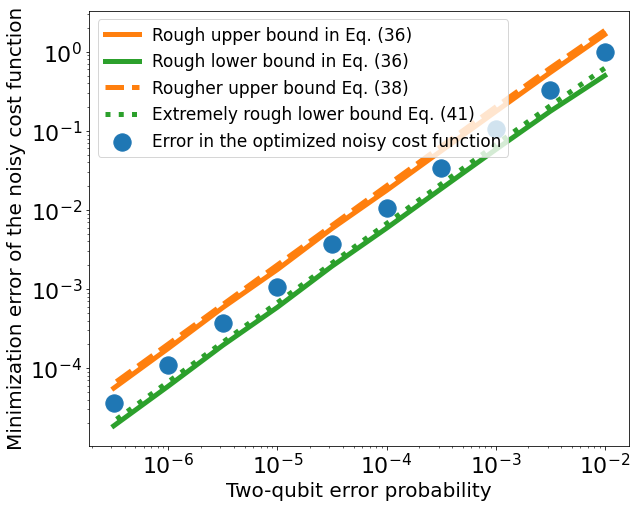

In [4]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))


noise_rate_list = np.array(noise_rate_list)

axes.scatter(noise_rate_list, error_list_H, label="Error in the optimized noisy cost function", s=300)
axes.plot(noise_rate_list, UB_list_H, label="Rough upper bound in Eq. (36)", color = 'tab:orange', lw = 5)
axes.plot(noise_rate_list, LB_list_H, label="Rough lower bound in Eq. (36)", color = 'tab:green', lw = 5)
axes.plot(noise_rate_list, UB_rougher_list_H, label="Rougher upper bound Eq. (38)", color = 'tab:orange', lw = 5, linestyle = 'dashed')
axes.plot(noise_rate_list, LB_extr_list_H, label="Extremely rough lower bound Eq. (41)", color = 'tab:green', linestyle = 'dotted', lw = 5)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.rc('legend',fontsize=17)

axes.set_yscale('log')
axes.set_xscale('log')

axes.set_xlabel('Two-qubit error probability', fontsize=20)
axes.set_ylabel('Minimization error of the noisy cost function', fontsize=20)

fig.subplots_adjust(left=0.15)

axes.legend(loc=2)

We can see that our rough bounds well capture the scaling of the true error dependence on the error probability.
We note that the bounds may be violated if the optimization of the parameters is not so good, and the noiseless precision is not good enough.

## Toy Model

We define a class to implement simulations for the toy model.

In [5]:
class ToyModel:
    '''
    Class for implementing simulations of VQE of Toy model Hamiltonian treated in our paper Ref. [1].
    The target groud state is constructed as the state created by a given circuit U(target_params)
    with a given target parameters target_params (randomly generated in this code).
    This Hamiltonian is constructed from this ground state and a given spectrum.
    It can evaluate rough bounds of the minimization error of the cost function given by an ALT ansatz.
    The noise model is a local depolarizing noise model, where k-qubit depolarizing channel is inserted after every k-qubit gate.
    Single-qubit depolarizing channel acting on each qubit is also added at the end of the circuit for a model of the readout error.
    The error probabilty of all single-qubit depolarizing channels after single-qubit gates are common.
    That is the same for two-qubit errors and readout errors.
    ----------
    nqubits : number of qubits
    depth : depth of the circuit
    E_0 : minimum eigenvalue
    E_1 : second minimum eigenvalue
    E_max : largest eigenvalue
    noise1Q_rate : error probability of single-qubit depolarizing channels
    noise2Q_rate : error probability of two-qubit depolarizing channels
    noiseRead_rate : error probability of single-qubit depolarizing channels at the end of the circuit
    '''
    def __init__(self, nqubits, depth, E_0, E_1, E_max, noise1Q_rate=1e-3, noise2Q_rate=1e-2, noiseRead_rate=1e-3):
        self.nqubits = nqubits
        self.depth = depth
        self.E_0 = E_0
        self.E_1 = E_1
        self.E_max = E_max
        self.noise1Q_rate = noise1Q_rate
        self.noise2Q_rate = noise2Q_rate
        self.noiseRead_rate = noiseRead_rate
        self.flag = 0
        
        self.basis_num = 2 ** nqubits
        self.noiseless_cost_val = []
        self.noisy_cost_val = []
        self.noiseless_circuit, self.gate_1Qcount, self.gate_2Qcount = periodic_ALT_noiseless(nqubits, depth, Output_gate_count=True)
        self.n_params = self.noiseless_circuit.get_parameter_count()
        self.target_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params) #target parameter
        self.target_circuit_dag = periodic_ALT_noiseless(nqubits, depth, Dagger=True, params=self.target_params)

        E_list = [self.E_0, self.E_1, self.E_max]
        E_geq2_list = np.random.uniform(self.E_1, self.E_max, (self.basis_num - 3)) #generate a random spectrum
        self.E_list = np.concatenate([E_list, E_geq2_list])
        
        self.proj_list = []
        indices = list(range(self.nqubits))
        for i in range(self.basis_num):
            proj = np.zeros((self.basis_num, self.basis_num), dtype=float)
            proj[i, i] = 1.
            self.proj_list.append(DenseMatrix(indices, proj))
        self.Ob_id = Observable(self.nqubits)
        self.Ob_id.add_operator(1., "I 0")
        
        self.rho = DensityMatrix(self.nqubits)
        self.state = QuantumState(self.nqubits)
        self.noise1Qrates = np.full(self.gate_1Qcount, self.noise1Q_rate)
        self.noise2Qrates = np.full(self.gate_2Qcount, self.noise2Q_rate)
        self.noiseReadrates = np.full(self.nqubits, self.noiseRead_rate)
        #noisy circuit is generated
        self.noisy_circuit = periodic_ALT_DP(self.nqubits, self.depth, noise1Q_rates=self.noise1Qrates, noise2Q_rates=self.noise2Qrates, noiseRead_rates=self.noiseReadrates)
        #error probabilities of the depolarizing channels are converted to the error probabilities in terms of the stochastic Pauli noise,
        #following [Lemma 1, Ref. 1].
        self.p_list_1Q = get_loc_DP_p_list(np.concatenate((self.noise1Qrates, self.noiseReadrates)), k=1)
        self.p_list_2Q = get_loc_DP_p_list(self.noise2Qrates, k=2)
        self.p_list = np.concatenate((self.p_list_1Q, self.p_list_2Q))

    def H_expect(self, state):
        state_b = state.copy()
        self.target_circuit_dag.update_quantum_state(state_b)
        energy = 0.
        for i in range(self.basis_num):
            state_c = state_b.copy()
            self.proj_list[i].update_quantum_state(state_c)
            energy += self.E_list[i] * self.Ob_id.get_expectation_value(state_c)
        return energy

    def noiseless_cost(self, list_para):
        self.state.set_zero_state()
        for i in range(len(list_para)):
            self.noiseless_circuit.set_parameter(i, list_para[i])
        self.noiseless_circuit.update_quantum_state(self.state)
        energy = self.H_expect(self.state)
        if (self.flag == 0):
            self.noiseless_cost_val.append(energy.real)
        return energy.real
    
    def G_i_exact_VP(self, params, concatenate=True):
        '''
        calculates exact values of G_i(params) (defined in Ref. [1])
        for virtual parameters associated with the depolarizing channels
        Args:
            params (list of float) : list of parameters
            concatenate (bool, optional) : If its value is True, this function returns whole G_i,
                otherwise it returns G_i for single-qubit and for two-qubit separately
        Returns:
        if concatenate=True
            G_i (list of float) : list of whole G_i. Note that the order is [G_i_1Q, G_i_2Q].
        if concatenate=False
            G_i_1Q (list of float) : list of G_i for virtual parameters associated with single-qubit depolarizing channels
            G_i_2Q (list of float) : list of G_i for virtual parameters associated with two-qubit depolarizing channels
        '''
        G_i_1Q, G_i_2Q = G_i_ALT_VPofDP(self.nqubits, self.depth, params)
        if concatenate:
            return np.concatenate((G_i_1Q, G_i_2Q))
        else:
            return G_i_1Q, G_i_2Q

    def noisy_cost(self, list_para):
        self.rho.set_zero_state()
        for i in range(len(list_para)):
            self.noisy_circuit.set_parameter(i, list_para[i])
        self.noisy_circuit.update_quantum_state(self.rho)
        energy = self.H_expect(self.rho)
        if (self.flag == 0):
            self.noisy_cost_val.append(energy.real)
        return energy.real
    
    #gradient based on the parameter shift rule
    def noiseless_grad(self, list_para, *args):
        self.flag = 1
        params = np.array(list_para)
        grad = np.zeros_like(params)
        shift = np.zeros_like(params)
        for i in range(len(params)):
            shift[i] = 0.5 * np.pi
            grad[i] = 0.5 * (self.noiseless_cost(params + shift) - self.noiseless_cost(params - shift))
            shift[i] = 0.
        self.flag = 0
        return np.array(grad)
    
    def noisy_grad(self, list_para, *args):
        self.flag = 1
        params = np.array(list_para)
        grad = np.zeros_like(params)
        shift = np.zeros_like(params)
        for i in range(len(params)):
            shift[i] = 0.5 * np.pi
            grad[i] = 0.5 * (self.noisy_cost(params + shift) - self.noisy_cost(params - shift))
            shift[i] = 0.
        self.flag = 0
        return np.array(grad)
    
    #optimization
    def run_noiseless_optimization(self, init_params=None, optimizer=scipy.optimize.fmin_bfgs, maxiter=100):
        self.noiseless_cost_val = []
        if init_params is None:
            init_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params)
        result = optimizer(self.noiseless_cost, init_params, fprime=self.noiseless_grad, args=(), maxiter=maxiter, full_output=1, disp=0, retall=0, callback=None)
        return result
    
    def run_noisy_optimization(self, init_params=None, optimizer=scipy.optimize.fmin_bfgs, maxiter=1000):
        self.noisy_cost_val = []
        if init_params is None:
            init_params = np.random.uniform(0.0, 2.0 * np.pi, self.n_params)
        result = optimizer(self.noisy_cost, init_params, fprime=self.noisy_grad, args=(), maxiter=maxiter, full_output=1, disp=0, retall=0)
        return result
    
    def run_noisy_opt_from_noiseless_sol(self, optimizer=scipy.optimize.fmin_bfgs, epsl_init=1e-5, maxiter_noiseless=100, maxiter_noisy=1000, callback=None):
        epsl = epsl_init
        noiseless_fval = self.E_0 + epsl + 1000
        start = time.time()
        while(noiseless_fval > self.E_0 + epsl):
            noiseless_res = self.run_noiseless_optimization(optimizer=optimizer, maxiter=maxiter_noiseless)
            noiseless_fval = self.noiseless_cost(noiseless_res[0])
        print("Error in the noiseless minimization:", noiseless_fval - E_0)
        elapsed_time = time.time() - start
        print ("Elapsed time for finding a good initial parameters:{0}".format(elapsed_time) + "[sec]")
        noisy_res = self.run_noisy_optimization(init_params=noiseless_res[0], optimizer=optimizer, maxiter=maxiter_noisy)
        noisy_fval = self.noisy_cost(noisy_res[0])
        results = {"init_params":noiseless_res[0], "noiseless_result":noiseless_res, "noiseless_fval":noiseless_fval, "noisy_result":noisy_res, "noisy_fval":noisy_fval}
        return results
    
    #rough bounds of the minimization error in the noisy cost function
    def all_rough_bounds(self, params, c=1.):
        '''
        Rough bounds in Ref. [1] are calculated for this toy model using the functions rough_LB and rough_UB defined in error_bounds.py module
        '''
        gap = self.E_1 - self.E_0
        spec_width = self.E_max - self.E_0
        G_list = self.G_i_exact_VP(params)
        LB = rough_LB(self.p_list, gap, G_list=G_list)
        LB_extr = rough_LB(self.p_list, gap, G_list=None, c=c)
        UB = rough_UB(self.p_list, spec_width, G_list=G_list)
        UB_rougher = rough_UB(self.p_list, spec_width, G_list=None)
        return LB_extr, UB_rougher, LB, UB


### Simulation of the VQE of the toy model under different error probabilities

Let us implement the VQE of the toy model. We calculate the minimization error of the noisy cost function under different error probabilities. In this example, we consider 4-qubit, 4-depth circuit, and 10 error probabilities for two-qubit errors given as $10^{-2} * 0.1^{i/2}$ $(i=0,1,\cdots,9)$.
All quantities are calculated exactly and include no shot noise.

To minimize the noisy cost function, we firstly calculate a minimal parameter for the noiseless cost function from a random initial parameters using `scipy.optimize.fmin_bfgs`.　This optimization is repeated until precision epsl_init is achieved. Then, we minimize the noisy cost function using the same optimizer starting from the obtained minimal parameter for the noiseless cost function. This procedure is implemented by method `ToyModel.run_noisy_opt_from_noiseless_sol`.

Then, rough upper and lower bounds are calculated by method `ToyModel.all_rough_bounds` at the obtained minimal point of the noisy cost function.

In [6]:
#number of qubits, depth
nqubits = 4
depth = 4

E_0 = 1.0 #minimum eigenvalue to obtain
E_max = 100.0 #maximum eigenvalue
E_1 = 21.0 #second largest eigenvalue

rate_mstep = np.sqrt(0.1)
rate_num = 10 
noise_rate_largest = 1e-2
#list of two-qubit error probabilities for which simulations are implemented
noise_rate_list = [noise_rate_largest * (rate_mstep ** i) for i in range(rate_num)]

model_list = []
results_list = []
error_list = []

LB_extr_list = []
UB_rougher_list = []
LB_list = []
UB_list = []

epsl_init = 1e-3
maxiter_noisy = 1000
maxiter_noiseless = 200
#start = time.time()
for noise2Q_rate in noise_rate_list:
    print("two-qubit error probability:", noise2Q_rate)
    noise1Q_rate = noise2Q_rate * 0.1
    noiseRead_rate = noise2Q_rate
    model = ToyModel(nqubits, depth, E_0, E_1, E_max,
                     noise1Q_rate=noise1Q_rate, noise2Q_rate=noise2Q_rate, noiseRead_rate=noiseRead_rate)
    model_list.append(model)
    n_params = model.n_params
    #run the optimization
    results = model.run_noisy_opt_from_noiseless_sol(epsl_init=epsl_init, maxiter_noiseless=maxiter_noiseless, maxiter_noisy=maxiter_noisy)
    results_list.append(results)
    #minimization error of the noisy cost function
    error = results['noisy_fval'] - E_0
    print("C_noisy(theta^*) - E_0:", error)
    error_list.append(error)
    #rough error bounds
    LB_extr, UB_rougher, LB, UB = model.all_rough_bounds(results['noisy_result'][0])
    LB_extr_list.append(LB_extr)
    UB_rougher_list.append(UB_rougher)
    LB_list.append(LB)
    UB_list.append(UB)
    print("rough upper bound:", UB)
    print("rougher upper bound:", UB_rougher)
    print("rough lower bound:", LB)
    print("extremely rough lower bound:", LB_extr)
    print("---------------------------")
#elapsed_time = time.time() - start
#print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

two-qubit error probability: 0.01
Error in the noiseless minimization: 6.782130412830156e-12
Elapsed time for finding a good initial parameters:1.3093540668487549[sec]
C_noisy(theta^*) - E_0: 9.171687352060585
rough upper bound: 13.879518258144154
rougher upper bound: 15.362534930577104
rough lower bound: 2.55135093914479
extremely rough lower bound: 3.103542410217597
---------------------------
two-qubit error probability: 0.0031622776601683794
Error in the noiseless minimization: 3.710365348297273e-13
Elapsed time for finding a good initial parameters:21.797732830047607[sec]
C_noisy(theta^*) - E_0: 3.144783757694716
rough upper bound: 4.617582924942773
rougher upper bound: 5.128103394984985
rough lower bound: 0.9057307650619045
extremely rough lower bound: 1.0359804838353504
---------------------------
two-qubit error probability: 0.001
Error in the noiseless minimization: 0.0009820661503665562
Elapsed time for finding a good initial parameters:6.0481462478637695[sec]
C_noisy(theta^*

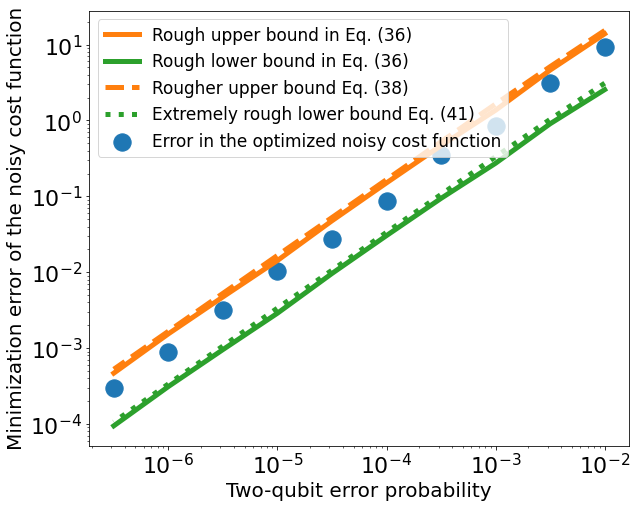

In [7]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))


noise_rate_list = np.array(noise_rate_list)

axes.scatter(noise_rate_list, error_list, label="Error in the optimized noisy cost function", s=300)
axes.plot(noise_rate_list, UB_list, label="Rough upper bound in Eq. (36)", color = 'tab:orange', lw = 5)
axes.plot(noise_rate_list, LB_list, label="Rough lower bound in Eq. (36)", color = 'tab:green', lw = 5)
axes.plot(noise_rate_list, UB_rougher_list, label="Rougher upper bound Eq. (38)", color = 'tab:orange', lw = 5, linestyle = 'dashed')
axes.plot(noise_rate_list, LB_extr_list, label="Extremely rough lower bound Eq. (41)", color = 'tab:green', linestyle = 'dotted', lw = 5)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.rc('legend',fontsize=17)

axes.set_yscale('log')
axes.set_xscale('log')

axes.set_xlabel('Two-qubit error probability', fontsize=20)
axes.set_ylabel('Minimization error of the noisy cost function', fontsize=20)

fig.subplots_adjust(left=0.15)

axes.legend(loc=2)

We can see that our rough bounds well capture the scaling of the true error dependence on the error probability as similar to the Heisenberg spin chain.
We note that the bounds may be violated if the optimization of the parameters is not so good, and the noiseless precision is not good enough.

### Simulation of the VQE of the toy model under different spectral gaps

Next, we calculate the minimization error of the noisy cost function under different spectral gaps $E_1 - E_0$. In this example, we consider 4-qubit, 4-depth circuit again, and 16 different gaps with $E_1 - E_0 \in \{20 + 5*i | i=0,1,\cdots,15\}$.
All quantities are calculated exactly and include no shot noise.

To minimize the noisy cost function, we firstly calculate a minimal parameter for the noiseless cost function from a random initial parameters using `scipy.optimize.fmin_bfgs`.　This optimization is repeated until precision epsl_init is achieved. Then, we minimize the noisy cost function using the same optimizer starting from the obtained minimal parameter for the noiseless cost function. This procedure is implemented by method `ToyModel.run_noisy_opt_from_noiseless_sol`.

Then, rough upper and lower bounds are calculated by method `ToyModel.all_rough_bounds` at the obtained minimal point of the noisy cost function.

In [10]:
nqubits = 4
depth = 4
E_0 = 1.0
E_max = 100.0
E_1 = 21.0

noise1Q_rate = 1e-3
noise2Q_rate = 1e-2
noiseRead_rate = 1e-2
gap_num = 16
gap_step = 5.0
#list of E_1 for which simulations are implemented
E_1_list = np.array([E_1 + gap_step*i for i in range(gap_num)])
gap_list = E_1_list - E_0
model_list_gap = []
results_list_gap = []
error_list_gap = []

LB_extr_list_gap = []
UB_rougher_list_gap = []
LB_list_gap = []
UB_list_gap = []

epsl_init = 1e-3
maxiter_noisy = 1000
maxiter_noiseless = 200
#start = time.time()
for E_1 in E_1_list:
    print("E_1 - E_0:", E_1 - E_0)
    noise1Q_rate = noise2Q_rate * 0.1
    noiseRead_rate = noise2Q_rate
    model = ToyModel(nqubits, depth, E_0, E_1, E_max,
                     noise1Q_rate=noise1Q_rate, noise2Q_rate=noise2Q_rate, noiseRead_rate=noiseRead_rate)
    model_list_gap.append(model)
    n_params = model.n_params
    results = model.run_noisy_opt_from_noiseless_sol(epsl_init=epsl_init, maxiter_noiseless=maxiter_noiseless, maxiter_noisy=maxiter_noisy)
    results_list_gap.append(results)
    error = results['noisy_fval'] - E_0
    print("C_noisy(theta^*) - E_0:", error)
    error_list_gap.append(error)
    LB_extr, UB_rougher, LB, UB = model.all_rough_bounds(results['noisy_result'][0])
    LB_extr_list_gap.append(LB_extr)
    UB_rougher_list_gap.append(UB_rougher)
    LB_list_gap.append(LB)
    UB_list_gap.append(UB)
    print("rough upper bound:", UB)
    print("rougher upper bound:", UB_rougher)
    print("rough lower bound:", LB)
    print("extremely rough lower bound:", LB_extr)
    print("---------------------------")
#elapsed_time = time.time() - start
#print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

E_1 - E_0: 20.0
Error in the noiseless minimization: 2.1738166822160565e-12
Elapsed time for finding a good initial parameters:91.39594388008118[sec]
C_noisy(theta^*) - E_0: 7.931066366794063
rough upper bound: 13.235025386986496
rougher upper bound: 15.362534930577104
rough lower bound: 2.4211503591129397
extremely rough lower bound: 3.103542410217597
---------------------------
E_1 - E_0: 25.0
Error in the noiseless minimization: 2.0607515693882306e-11
Elapsed time for finding a good initial parameters:29.30499005317688[sec]
C_noisy(theta^*) - E_0: 7.596717550019756
rough upper bound: 14.08584166267297
rougher upper bound: 15.362534930577104
rough lower bound: 3.2412905437614965
extremely rough lower bound: 3.879428012771996
---------------------------
E_1 - E_0: 30.0
Error in the noiseless minimization: 1.6277096338779273e-05
Elapsed time for finding a good initial parameters:4.2670793533325195[sec]
C_noisy(theta^*) - E_0: 8.039418116601324
rough upper bound: 13.852033015464112
roug

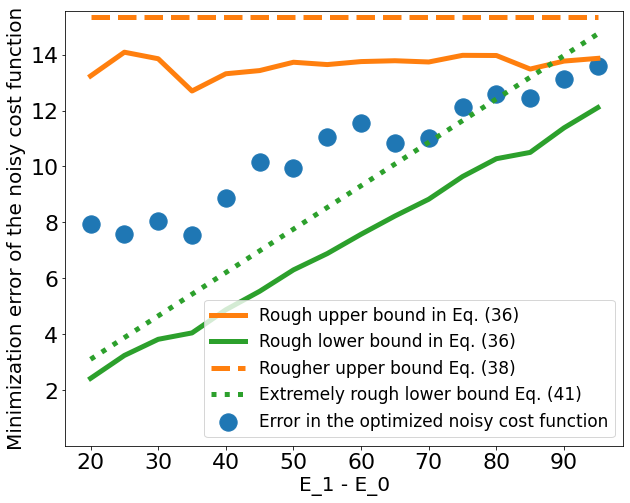

In [11]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.scatter(gap_list, error_list_gap, label="Error in the optimized noisy cost function", s=300)
axes.plot(gap_list, UB_list_gap, label="Rough upper bound in Eq. (36)", color='tab:orange', lw=5)
axes.plot(gap_list, LB_list_gap, label="Rough lower bound in Eq. (36)", color='tab:green', lw=5)
axes.plot(gap_list, UB_rougher_list_gap, label="Rougher upper bound Eq. (38)", color='tab:orange', lw=5, linestyle='dashed')
axes.plot(gap_list, LB_extr_list_gap, label="Extremely rough lower bound Eq. (41)", color='tab:green', lw=5, linestyle='dotted')

plt.ylim(0.01, UB_rougher_list_gap[0]+0.2)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.rc('legend',fontsize=17)

axes.set_xlabel('E_1 - E_0', fontsize=20)
axes.set_ylabel('Minimization error of the noisy cost function', fontsize=20)


axes.legend(loc=0)

Up to the moderate size of the gap, all the bounds including extremely rough lower bound (41) actually work well.
However, for large gaps, extremely rough lower bound (41) breaks down and overestimates the error because the impact of the error in the rough approximation $G_{i_1,i_2,\cdots,i_k}(\vec{\theta}^*)\approx 1$ is emphasized by the large value of the gap $E_1 - E_0$.
This result also implies that the error tends to increase as the gap gets large as implied by the lower bound.